# Anomaly Detection in High Dimensions Using Auto-encoder
Anomaly detection detects data points (outliers) which do not conform to an expected pattern or other items in a dataset. In statistics, anomalies, also known as outliers, are observation points that are distant from other observations. In this notebook we demonstrate how to do unsupervised anomaly detection in high dimensions using auto-encoder.

We are using one of the HiCS realworld data sets ([link](https://www.ipd.kit.edu/~muellere/HiCS)) for demo. The data set contains 32 dimensions and 351 instances, with 126 of them being outliers. Alternative datasets are in the same directory, however, typically datasets with higher dimension and lower outlier proportion will have a better performance. Data points with higher reconstruction error are more likely to be outliers, and this notebook can also show which dimensions the points are outlying.

References:
* [Neural-based Outlier Discovery](https://edouardfouche.com/Neural-based-Outlier-Discovery)

## Initialization
Initilize nn context and load data

In [3]:
from bigdl.dllib.nncontext import *
sc = init_nncontext("Anomaly Detection HD Example")

from scipy.io import arff
import pandas as pd
import os

dataset = "ionosphere"           #real world dataset
data_dir = os.getenv("BIGDL_HOME")+"/bin/data/HiCS/"+dataset+".arff"
rawdata, _ = arff.loadarff(data_dir)
data = pd.DataFrame(rawdata)

The dataset contains 32 dimensions and 351 instances, with 126 of them being outliers.

In [4]:
data.head(5)

,var_0000,var_0001,var_0002,var_0003,var_0004,var_0005,var_0006,var_0007,var_0008,var_0009,...,var_0023,var_0024,var_0025,var_0026,var_0027,var_0028,var_0029,var_0030,var_0031,class
0,0.997695,0.470555,0.926215,0.511530,0.91699,0.311460,1.000000,0.518800,0.926215,0.411225,...,0.244145,0.705390,0.269160,0.606330,0.329550,0.711335,0.227565,0.593205,0.273500,b'0'
1,1.000000,0.405855,0.965175,0.319220,0.44566,0.032015,1.000000,0.477255,0.754370,0.161285,...,0.367155,0.397660,0.407995,0.404800,0.442035,0.416870,0.468560,0.431310,0.487765,b'1'
2,1.000000,0.483175,1.000000,0.502425,1.00000,0.439690,0.944825,0.505990,0.865410,0.526730,...,0.298900,0.794920,0.389275,0.715500,0.413175,0.802180,0.379100,0.780225,0.308810,b'0'
3,1.000000,0.274195,1.000000,1.000000,0.85608,0.000000,0.500000,0.500000,0.500000,0.500000,...,0.953475,0.758065,1.000000,1.000000,0.399505,0.628410,1.000000,0.338090,1.000000,b'1'
4,1.000000,0.487995,0.970700,0.532655,0.96053,0.383725,0.885760,0.418005,0.763990,0.398625,...,0.174210,0.566450,0.233970,0.512155,0.189015,0.471465,0.202135,0.476960,0.171515,b'0'


## Data preprocessing
Generate labels and normalize the data between 0 and 1.

generate labels

In [5]:
labels = data['class'].astype(int)
del data['class']

labels[labels != 0] = 1

MinMaxScaler is used since we need to keep the features of outliers

In [6]:
from sklearn.preprocessing import MinMaxScaler
data_norm = MinMaxScaler().fit_transform(data).astype('float32')

In [7]:
print("Instances: %d \nOutliers: %d\nAttributes: %d" % (len(data), sum(labels), len(data_norm[0])))

Instances: 351 
Outliers: 126
Attributes: 32


## Build the model

In [8]:
from bigdl.dllib.keras.layers import Input, Dense
from bigdl.dllib.keras.models import Model

compress_rate=0.8
origin_dim=len(data_norm[0])

input = Input(shape=(origin_dim,))
encoded = Dense(int(compress_rate*origin_dim), activation='relu')(input)
decoded = Dense(origin_dim, activation='sigmoid')(encoded)
autoencoder = Model(input, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createAdadelta
creating: createZooKerasBinaryCrossEntropy


## Training

In [9]:
autoencoder.fit(x=data_norm,
                y=data_norm,
                batch_size=100,
                nb_epoch=2500,
                validation_data=None)

## Prediction
Data are encoded and reconstructed as data_trans

In [10]:
data_trans = autoencoder.predict(data_norm).collect()

## Evaluation
Calculate the euclidean distance for each point from ground truth to its reconstruction. The further the distance is, the more likely the point will be an outlier.

In [11]:
import numpy as np
dist = []
for i, x in enumerate(data_norm):
    dist.append(np.linalg.norm(data_norm[i] - data_trans[i]))
dist=np.array(dist)

Plot the ROC curve to assess the quality of anomaly detection. Here, we have achieved an AUC of 0.94 which is very good.

AUC = 0.941940


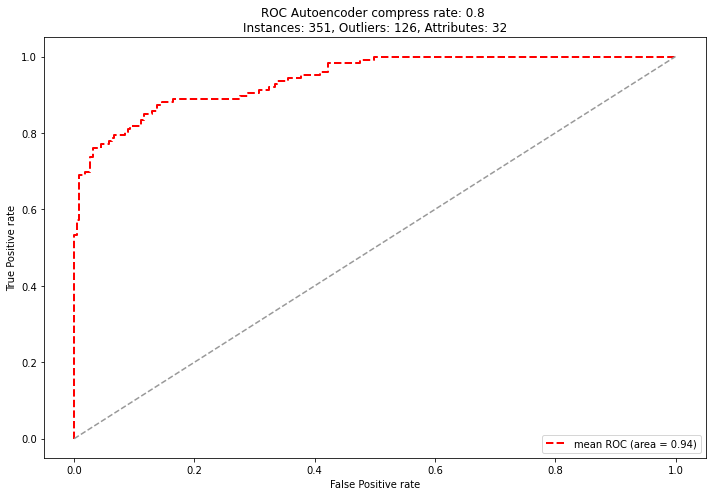

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, threshold = roc_curve(labels, dist)
roc_auc = auc(fpr, tpr)
print('AUC = %f' % roc_auc)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, 'k--',
         label='mean ROC (area = %0.2f)' % roc_auc, lw=2, color='red')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Autoencoder compress rate: %0.1f ' % compress_rate + "\nInstances: %d, Outliers: %d, Attributes: %d" % (len(data), sum(labels), len(data_norm[0])))
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Plot the outlier scores for each single data point. The higher scores should represent higher possibility of being outliers. Compared to the ground truth, where positive data points are indicated as red and negative as blue, positive data points have a much higher outlier score than negative points as expected. 

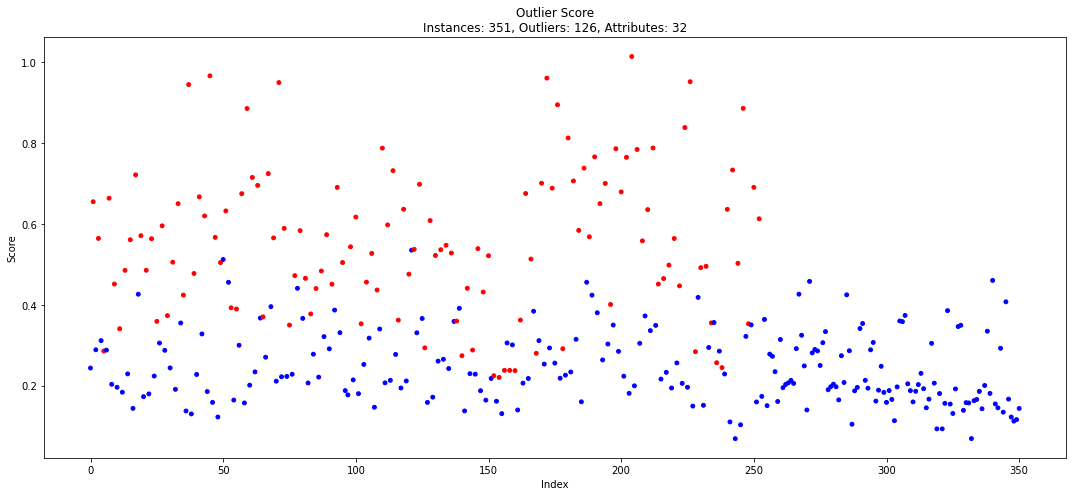

In [13]:
plt.figure(figsize=(15, 7))
label_colors=[]*len(labels)
label_colors = list(map(lambda x: "r" if x==1 else "b", labels))  
plt.scatter(data.index, dist, c=label_colors, s=15)
plt.xlabel('Index')
plt.ylabel('Score')
plt.title("Outlier Score\nInstances: %d, Outliers: %d, Attributes: %d" % (len(data), sum(labels), len(data_norm[0])))
plt.tight_layout()
#plt.savefig("./fig/"+dataset+".score.png")
plt.show()

Show top 20 data points with highest outlier score in descending order

In [14]:
outlier_indices = np.argsort(-dist)[0:20]
print(outlier_indices)

[204  45 172 226  71  37 176 246  59 224 180 212 110 198 206 190 202 186
 242 114]


By looking at the reconstruction error, we can find hints about the dimensions in which a particular data point is outlying.
Here, we plot the reconstruction error in dimension at data point of 204 which has the second highest outlier score.

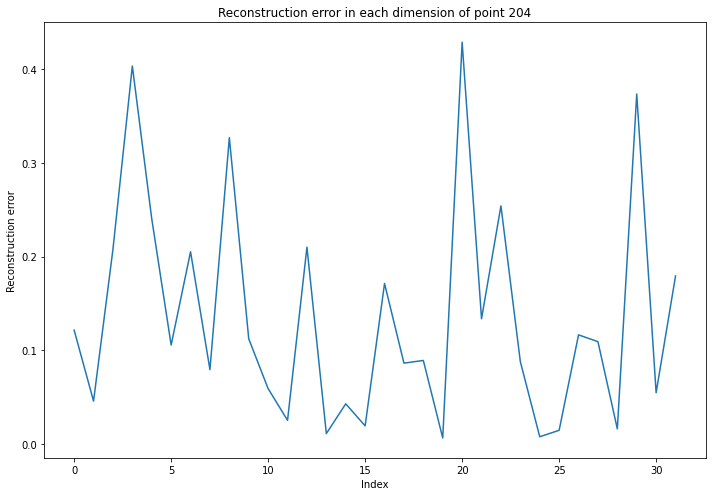

In [15]:
def error_in_dim(index):
    error = []
    for i, x in enumerate(data_norm[index]):
        error.append(abs(data_norm[index][i] - data_trans[index][i]))
    error=np.array(error)
    return error

example = 204

plt.figure(figsize=(10,7))
plt.plot(error_in_dim(example))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point %d" % example)
plt.tight_layout()
plt.show()

Show top 3 dimensions with highest reconstruction error in descending order. Data point of 204 has high reconstruction error at subspace of [8,23,29].

In [16]:
print(np.argsort(-error_in_dim(example))[0:3])

[20  3 29]


Look at the position of the point in a subspace [28,29,30], data point of 204 as an outlier, indicated as red dot is far away from other data points.

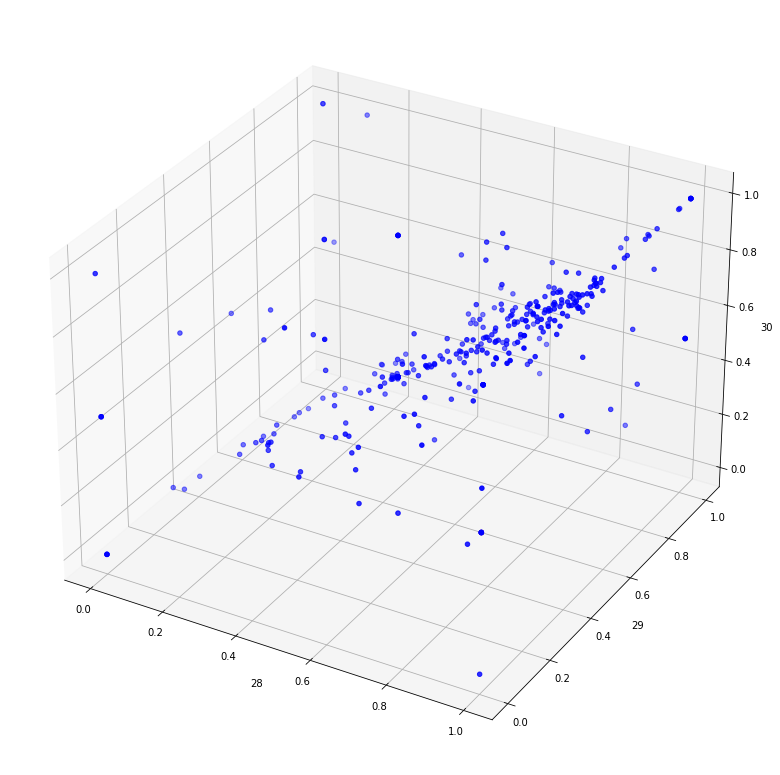

In [17]:
indicator = ['b']*len(data)
indicator[204] = 'r'
indicator=pd.Series(indicator)

from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(20,14)).gca(projection='3d')
threedee.scatter(data['var_0028'], data['var_0029'], zs=data['var_0030'], 
                 c=indicator)
threedee.set_xlabel('28')
threedee.set_ylabel('29')
threedee.set_zlabel('30')
plt.show()

You can find back the information in which each object is an outlier by looking at the reconstruction errors, or at least reduce drastically the search space. Here, we plot the reconstruction errors of outliers in the subspace of [8], data points of 21 232, 212, 100, 122, 19.

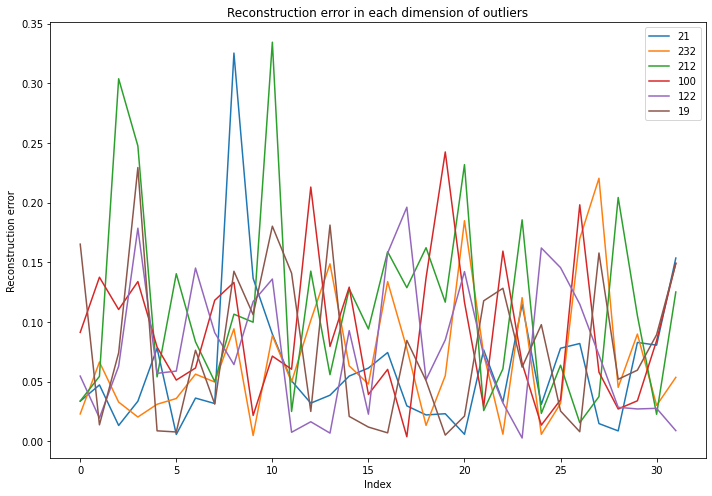

In [18]:
plt.figure(figsize=(10,7))
outliers = [21, 232, 212, 100, 122, 19]
for i in outliers:
    plt.plot(error_in_dim(i), label=i)
plt.legend(loc=1)
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of outliers")
plt.tight_layout()
plt.show()

Generally look into the subspace of [6,7,8] for the full dataset, the outliers are indicated as red dots, we can find out that a couple of data points are outlying. 

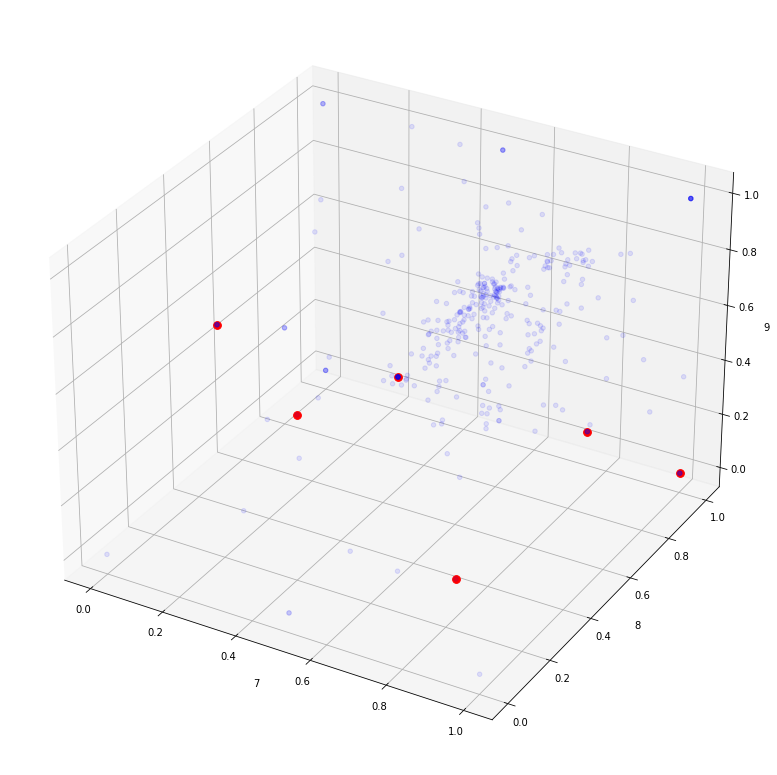

In [19]:
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(20,14)).gca(projection='3d')

threedee.scatter(data['var_0007'], data['var_0008'], zs=data['var_0009'], c='b', alpha=0.1)

for i in outliers:
    threedee.scatter(data['var_0007'][i], data['var_0008'][i], zs=data['var_0009'][i], c="r", s=60)
    #print(data['var_0007'][i], data['var_0008'][i], data['var_0009'][i])

threedee.set_xlabel('7')
threedee.set_ylabel('8')
threedee.set_zlabel('9')
plt.show()